# Opentender.eu datasets for UK and EU filtered notices

## Load and transform dataset
Datasets downloaded in json format from https://opentender.eu/all/download for EU institutions. Extract and store the archives in `data_json_opentender/data-uk-json`.

In [2]:
country_code = "uk"

In [3]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    # finally, compute metrics
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [4]:
import pandas as pd
df_uk = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv", index_col=0)
df_uk.head()

title_description     71     44     50  \
0   venue hire clutha fatal accident inquiry hire...  False  False  False   
1   rehabilitation reablement service southwark c...  False  False  False   
3   london quadrant housing trust supply bike sta...  False  False  False   
5   NUMBER healthy child programme delivery NUMBE...  False  False  False   
6   nexNUMBER NUMBER security service nexus curre...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False   True  False  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False  False  False   
5  False  False  False   True  False  False  ...  False  False  False  False   
6  False  False  False  False   True  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
3  False  False  False  False  False  False  
5  False  False  False  False  False  False  
6  False  False  False  False  False  False  

[5 rows x 46 columns]

Get preprocessed EU filtered notices generated from https://code.europa.eu/ted-ai/ml-experiments/cpv-classification/-/blob/master/20230214-data_exploration_and_training.ipynb

In [5]:
df_eu_filtered = pd.read_csv("20230214-dataset_preprocessed_with_lemma.csv", index_col=0)
df_eu_filtered.head(1)

title_texte     85    44     50  \
1   ipa supply equipment increase competitiveness...  False  True  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  

[1 rows x 46 columns]

In [6]:
df_eu_filtered["title_description"] = df_eu_filtered["title_texte"]
df_eu_filtered.drop(['title_texte'], axis=1, inplace=True)
df_eu_filtered = df_eu_filtered[df_uk.columns.to_list()]
df_eu_filtered.head(1)

title_description     71    44     50  \
1   ipa supply equipment increase competitiveness...  False  True  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
1  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  

[1 rows x 46 columns]

In [7]:
df = pd.concat([df_eu_filtered, df_uk])
df.head(1)

title_description     71    44     50  \
1   ipa supply equipment increase competitiveness...  False  True  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
1  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  

[1 rows x 46 columns]

In [8]:
df.describe()

title_description      71      44      50      80      73      45  \
count             400827  400827  400827  400827  400827  400827  400827   
unique            400811       2       2       2       2       2       2   
top       clean service    False   False   False   False   False   False   
freq                   2  366584  386437  380099  382170  379636  336222   

            85      79      90  ...      18      03      43      24      19  \
count   400827  400827  400827  ...  400827  400827  400827  400827  400827   
unique       2       2       2  ...       2       2       2       2       2   
top      False   False   False  ...   False   False   False   False   False   
freq    366525  348859  382868  ...  398849  398463  398605  399005  400229   

            41      37      14      16      76  
count   400827  400827  400827  400827  400827  
unique       2       2       2       2       2  
top      False   False   False   False   False  
freq    400659  398621  399952  399792  400419  

[4 rows x 46 columns]

In [9]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

Text(0.5, 0, 'CPV division')

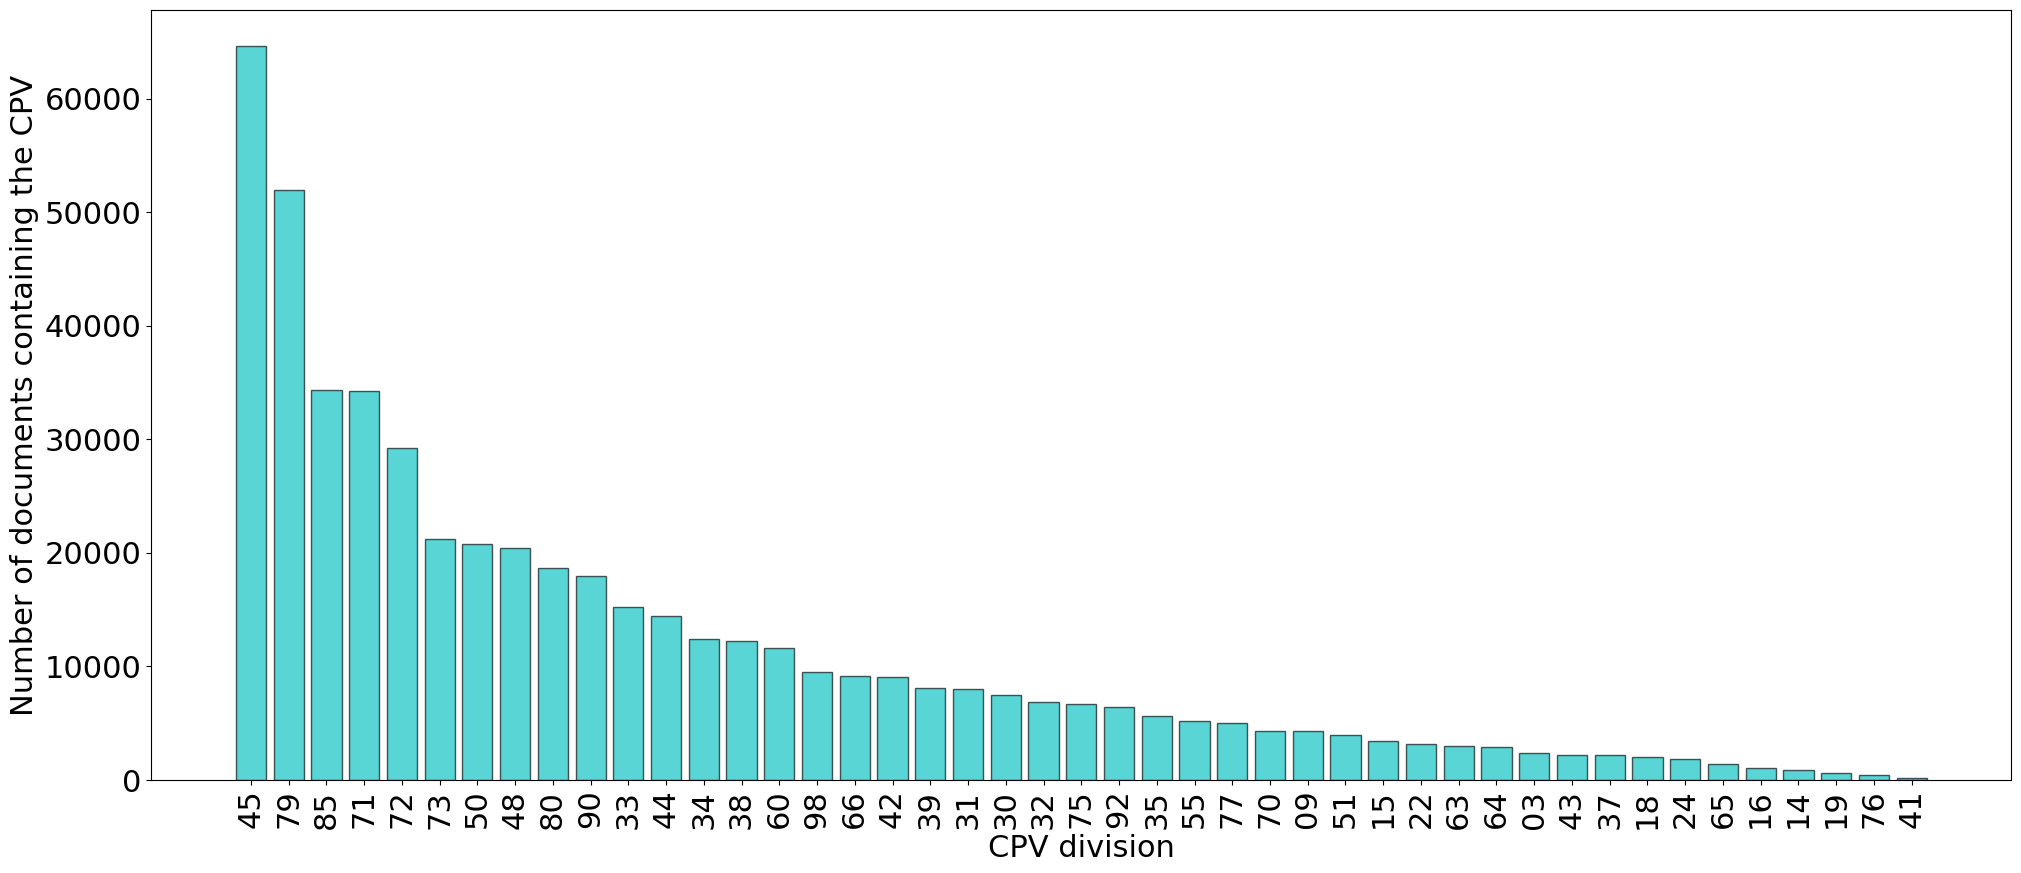

In [10]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")

## Train model

In [11]:
from sklearn import metrics

X = df['title_description']
Y = df.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)


clf fit done


In [12]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.73      0.59      0.66      6751
          44       0.65      0.45      0.53      2916
          50       0.72      0.57      0.64      4187
          80       0.83      0.73      0.78      3731
          73       0.73      0.61      0.66      4153
          45       0.83      0.83      0.83     12954
          85       0.88      0.85      0.86      6928
          79       0.75      0.66      0.70     10333
          90       0.83      0.72      0.77      3602
          30       0.69      0.50      0.58      1502
          35       0.66      0.44      0.52      1093
          33       0.81      0.73      0.76      3102
          55       0.84      0.75      0.79       997
          72       0.65      0.55      0.60      5832
          48       0.68      0.62      0.64      4152
          38       0.76      0.70      0.73      2449
          09       0.82      0.72      0.77       855
          75       0.77    

## Predictions on data from other countries

In [13]:
list_of_countries = ["ie", "no", "uk", "eu"]
list_of_countries.remove(country_code)

for country in list_of_countries:
    df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country}_only_no_filters.csv", index_col=0)
    print("====================================================\n")
    print(f"Country: {country}")
    X = df['title_description']
    Y = df.drop(['title_description'], axis=1)
    y_pred = SVC_pipeline.predict(X)
    print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
    print(multi_label_metrics(Y, y_pred))
    print("====================================================\n")



Country: ie


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.84      0.49      0.61     14326
          44       0.52      0.15      0.23      5163
          50       0.67      0.30      0.42      5009
          80       0.84      0.52      0.64      4701
          73       0.56      0.22      0.32      3487
          45       0.84      0.77      0.80     23424
          85       0.66      0.42      0.51      2068
          79       0.76      0.51      0.61     13945
          90       0.79      0.49      0.61      4534
          30       0.75      0.35      0.48      3096
          35       0.70      0.20      0.32      1804
          33       0.80      0.44      0.57      3953
          55       0.85      0.60      0.71      1419
          72       0.75      0.44      0.56     10273
          48       0.60      0.43      0.50      4918
          38       0.77      0.49      0.60      3699
          09       0.71      0.53      0.61       957
          75       0.48    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.71      0.14      0.23     20912
          44       0.55      0.04      0.07      9433
          50       0.47      0.07      0.11      7632
          80       0.52      0.05      0.09      6441
          73       0.51      0.05      0.09      6186
          45       0.69      0.06      0.11     85428
          85       0.41      0.08      0.13      4884
          79       0.46      0.20      0.28     13142
          90       0.81      0.23      0.36     11340
          30       0.85      0.14      0.24      7246
          35       0.37      0.05      0.09      2382
          33       0.74      0.18      0.28     12894
          55       0.79      0.11      0.20      1879
          72       0.62      0.17      0.26     13998
          48       0.52      0.13      0.21      8659
          38       0.61      0.21      0.31      5376
          09       0.80      0.17      0.28      1992
          75       0.10    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          71       0.27      0.20      0.23       465
          44       0.23      0.01      0.02      1604
          50       0.61      0.08      0.14       848
          80       0.74      0.56      0.64       230
          73       0.73      0.69      0.71       428
          45       0.20      0.11      0.14       436
          85       0.35      0.25      0.29       249
          79       0.32      0.57      0.41      1352
          90       0.68      0.23      0.35       331
          30       0.82      0.33      0.47      2189
          35       0.48      0.08      0.14       236
          33       0.86      0.30      0.44      7918
          55       0.83      0.36      0.50        95
          72       0.57      0.52      0.54       493
          48       0.42      0.32      0.36       171
          38       0.29      0.26      0.27       279
          09       0.58      0.11      0.18       168
          75       0.74    

## Predictions on dataset since january 2023
Dataset available on S3: s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20220221-dataset_since_january_2023.csv ; 

In [14]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [15]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline.predict(X)
print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

              precision    recall  f1-score   support

          71       0.73      0.89      0.80         9
          44       0.00      0.00      0.00         1
          50       0.67      0.67      0.67         3
          80       1.00      0.83      0.91         6
          73       0.67      0.57      0.62         7
          45       1.00      0.86      0.92        14
          85       1.00      0.67      0.80         3
          79       0.96      0.85      0.90        26
          90       1.00      0.71      0.83         7
          30       0.67      1.00      0.80         2
          35       0.75      1.00      0.86         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.86      0.86      0.86         7
          48       0.33      0.50      0.40         2
          38       0.33      1.00      0.50         1
          09       0.00      0.00      0.00         0
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a